# Lecture 4: Fixed-Income Securities I — Bond Pricing, Spot Rates, and the Term Structure

## MIT 15.401 — Finance Theory I (Prof. Andrew Lo)

---

**Video:** [MIT OCW — Part I & II of Fixed-Income Securities](https://ocw.mit.edu/courses/15-401-finance-theory-i-fall-2008/pages/video-lectures-and-slides/fixed-income-securities/)

**Readings:** Brealey, Myers, and Allen — Chapters 23–25; Sundaresan, *Fixed Income Markets and Their Derivatives*

---

This notebook begins the **Fixed-Income Securities** block (Sessions 4–7), which applies the present value machinery to the largest asset class in the world. The US bond market alone exceeded \$26 trillion in outstanding debt in 2006 — dwarfing the equity market.

Session 4 covers the foundations: what fixed-income securities are, how to price **discount (zero-coupon) bonds**, the concept of **spot rates** and the **term structure of interest rates**, how to extract **forward rates** from the yield curve, and how to value **coupon bonds** using both spot rates and the yield-to-maturity (YTM) convention.

This lecture is heavy on **notation** but light on new *conceptual* challenges — everything builds on the NPV framework from Sessions 2–3. The key new insight is that the yield curve embeds the market's **expectations** about future interest rates.

## Table of Contents

1. [Industry Overview — The Bond Market](#1-overview)
2. [Valuation of Discount (Zero-Coupon) Bonds](#2-discount-bonds)
3. [Spot Rates and the Term Structure](#3-spot-rates)
4. [Forward Rates](#4-forward-rates)
5. [Valuation of Coupon Bonds](#5-coupon-bonds)
6. [Yield to Maturity](#6-ytm)
7. [Bond Price Properties](#7-bond-properties)
8. [Exercises](#8-exercises)

In [3]:
# ============================================================
# Setup
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.optimize import brentq
from IPython.display import display, Markdown

plt.rcParams.update({
    'figure.figsize': (10, 5),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 12,
    'lines.linewidth': 2,
})

print("Libraries loaded successfully.")

Libraries loaded successfully.


---

<a id='1-overview'></a>
## 1. Industry Overview — The Bond Market

### What Are Fixed-Income Securities?

Fixed-income securities are financial claims with **promised cash flows of known fixed amount paid at fixed dates**. The key word is *promised* — the cash flows are contractually specified, unlike equities where dividends are uncertain.

### Classification

| Category | Examples |
|----------|----------|
| **Treasury Securities** | US T-bills (< 1 year), T-notes (1–10 years), T-bonds (10–30 years) |
| **Federal Agency** | FNMA (Fannie Mae), FHLMC (Freddie Mac), GNMA (Ginnie Mae) |
| **Corporate** | Commercial paper, medium-term notes (MTNs), corporate bonds |
| **Municipal** | State and local government bonds (often tax-exempt) |
| **Mortgage-Backed** | Pass-throughs, CMOs, RMBS, CMBS |
| **Asset-Backed** | Securities backed by auto loans, credit cards, student loans |
| **Derivatives** | CDOs, CDS, interest rate swaps |

### Market Scale

The US bond market in 2006 (Lo's data): \$26.7 trillion outstanding — roughly split as mortgage-related (24%), corporate (19%), Treasury (16%), money markets (14%), federal agency (10%), municipal (9%), and asset-backed (8%).

### Market Participants

**Issuers:** Governments, corporations, banks, municipalities, SPVs, foreign institutions. **Intermediaries:** Primary dealers, investment banks, rating agencies (Moody's, S&P, Fitch). **Investors:** Pension funds, insurance companies, mutual funds, hedge funds, central banks, individuals.

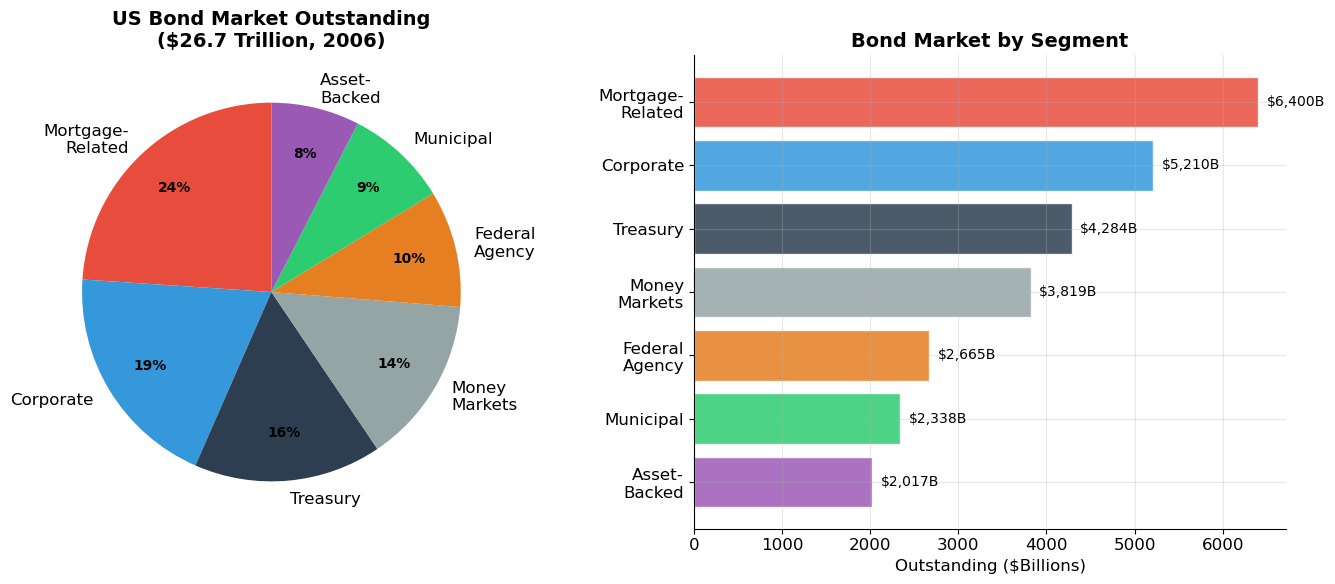

Total US bond market: $26,732.2 billion = $26.7 trillion


In [5]:
# ============================================================
# US Bond Market Composition (Lo's 2006 data)
# ============================================================
categories = ['Mortgage-\nRelated', 'Corporate', 'Treasury', 'Money\nMarkets',
              'Federal\nAgency', 'Municipal', 'Asset-\nBacked']
outstanding = [6400.4, 5209.7, 4283.8, 3818.9, 2665.2, 2337.5, 2016.7]
colors = ['#e74c3c', '#3498db', '#2c3e50', '#95a5a6', '#e67e22', '#2ecc71', '#9b59b6']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
wedges, texts, autotexts = ax1.pie(outstanding, labels=categories, autopct='%1.0f%%',
                                    colors=colors, startangle=90, pctdistance=0.75)
for t in autotexts:
    t.set_fontsize(10)
    t.set_fontweight('bold')
ax1.set_title('US Bond Market Outstanding\n($26.7 Trillion, 2006)', fontsize=14, fontweight='bold')

# Bar chart
sorted_idx = np.argsort(outstanding)[::-1]
sorted_cats = [categories[i] for i in sorted_idx]
sorted_vals = [outstanding[i] for i in sorted_idx]
sorted_colors = [colors[i] for i in sorted_idx]
bars = ax2.barh(sorted_cats, sorted_vals, color=sorted_colors, alpha=0.85, edgecolor='white')
ax2.set_xlabel('Outstanding ($Billions)')
ax2.set_title('Bond Market by Segment', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
for bar, val in zip(bars, sorted_vals):
    ax2.text(val + 100, bar.get_y() + bar.get_height()/2,
            f'${val:,.0f}B', va='center', fontsize=10)

plt.tight_layout()
plt.show()

total = sum(outstanding)
print(f"Total US bond market: ${total:,.1f} billion = ${total/1000:.1f} trillion")

---

<a id='2-discount-bonds'></a>
## 2. Valuation of Discount (Zero-Coupon) Bonds

### Definition

A **pure discount bond** (or zero-coupon bond) pays a single cash flow — the **face value** $F$ — at maturity date $T$. There are no intermediate coupon payments.

Examples: US **Treasury bills** (maturities < 1 year) and **STRIPS** (Separate Trading of Registered Interest and Principal Securities, maturities up to 30 years).

### Pricing

The price of a discount bond is simply the present value of its face value:

$$\boxed{P_0 = \frac{F}{(1 + r_{0,T})^T}}$$

where $r_{0,T}$ is the **spot rate** — the annualized yield for lending from today (time 0) to time $T$.

Note that $(P_0, F, r_{0,T})$ form a system of three variables with one equation — given any two, the third is determined. In particular, from observed prices we can **extract** spot rates:

$$r_{0,T} = \left(\frac{F}{P_0}\right)^{1/T} - 1$$

### Lo's STRIPS Example (August 1, 2001)

| Maturity | Price (per \$1 face) | Implied Spot Rate |
|----------|---------------------|------------------|
| 3 months | 0.991 | — |
| 6 months | 0.983 | — |
| 1 year | 0.967 | 3.41% |
| 2 years | 0.927 | 3.82% |
| 5 years | 0.797 | 4.64% |
| 10 years | 0.605 | 5.15% |
| 30 years | 0.187 | 5.64% |

STRIPS PRICES AND IMPLIED SPOT RATES (August 1, 2001)
  Maturity      Price    Spot Rate  Discount Factor
-----------------------------------------------------------------
      0.25      0.991      3.6825%           0.9910
      0.50      0.983      3.4887%           0.9830
      1.00      0.967      3.4126%           0.9670
      2.00      0.927      3.8628%           0.9270
      5.00      0.797      4.6426%           0.7970
     10.00      0.605      5.1537%           0.6050
     30.00      0.187      5.7479%           0.1870


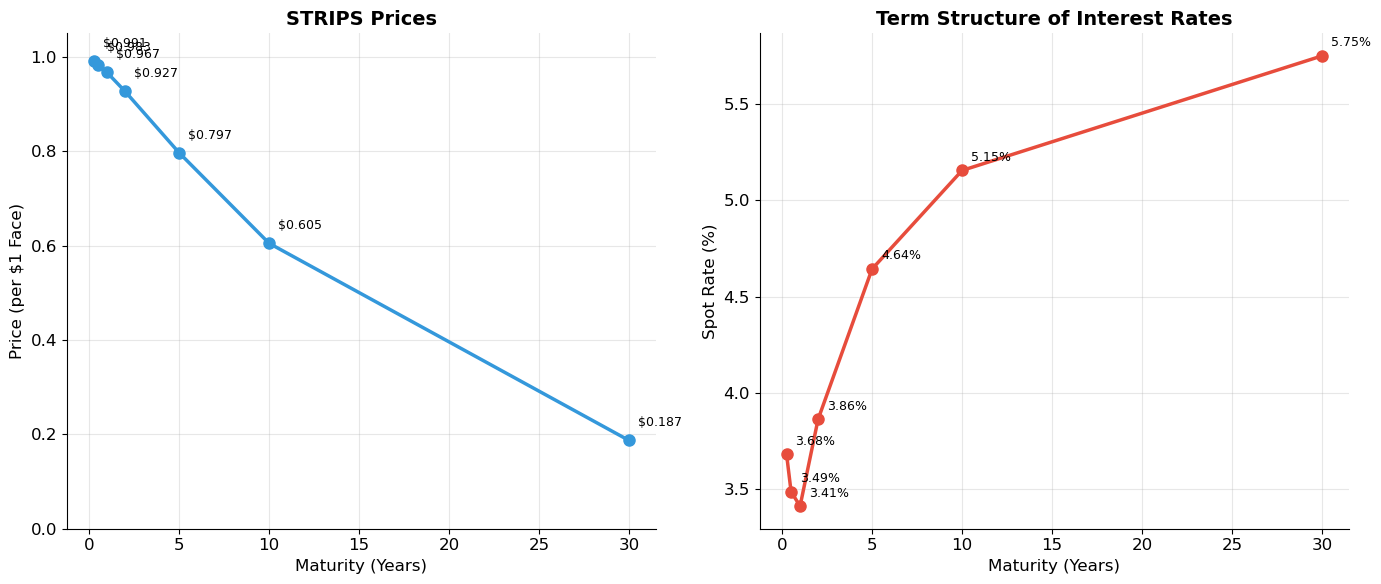

In [7]:
# ============================================================
# STRIPS Pricing and Spot Rate Extraction
# ============================================================
strips_data = {
    0.25: 0.991,
    0.50: 0.983,
    1:    0.967,
    2:    0.927,
    5:    0.797,
    10:   0.605,
    30:   0.187,
}

print("=" * 65)
print("STRIPS PRICES AND IMPLIED SPOT RATES (August 1, 2001)")
print("=" * 65)
print(f"{'Maturity':>10s} {'Price':>10s} {'Spot Rate':>12s} {'Discount Factor':>16s}")
print("-" * 65)

maturities, spot_rates, prices = [], [], []
for T, P in strips_data.items():
    r = (1 / P)**(1 / T) - 1
    maturities.append(T)
    spot_rates.append(r)
    prices.append(P)
    print(f"{T:>10.2f} {P:>10.3f} {r:>12.4%} {P:>16.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Discount bond prices
ax1.plot(maturities, prices, 'o-', color='#3498db', linewidth=2.5, markersize=8)
ax1.set_xlabel('Maturity (Years)', fontsize=12)
ax1.set_ylabel('Price (per $1 Face)', fontsize=12)
ax1.set_title('STRIPS Prices', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 1.05)
for m, p in zip(maturities, prices):
    ax1.annotate(f'${p:.3f}', xy=(m, p), xytext=(m + 0.5, p + 0.03), fontsize=9)

# Right: Term structure (spot rates)
ax2.plot(maturities, [r * 100 for r in spot_rates], 'o-', color='#e74c3c', linewidth=2.5, markersize=8)
ax2.set_xlabel('Maturity (Years)', fontsize=12)
ax2.set_ylabel('Spot Rate (%)', fontsize=12)
ax2.set_title('Term Structure of Interest Rates', fontsize=14, fontweight='bold')
for m, r in zip(maturities, spot_rates):
    ax2.annotate(f'{r:.2%}', xy=(m, r * 100), xytext=(m + 0.5, r * 100 + 0.05), fontsize=9)

plt.tight_layout()
plt.show()

---

<a id='3-spot-rates'></a>
## 3. Spot Rates and the Term Structure

### Notation

We need careful notation because interest rates now vary by maturity.

| Symbol | Meaning |
|--------|---------|
| $r_{0,T}$ | **Spot rate**: today's annualized rate for lending/borrowing from $t=0$ to $t=T$ |
| $R_t$ | **Future one-period spot rate**: the one-year rate that will prevail in year $t$ (unknown today) |
| $f_t$ | **Forward rate**: today's rate for a one-year loan beginning in year $t-1$ (known today, implied by the term structure) |
| $B_T$ or $P_{0,T}$ | Price today of a discount bond maturing at $T$ |

### The Relationship Between Spot Rates and Future Rates

Today's $T$-year spot rate is a **geometric average** of future one-period rates:

$$(1 + r_{0,T})^T = (1 + R_1)(1 + R_2) \cdots (1 + R_T)$$

But we **don't observe** the future rates $R_1, R_2, \ldots, R_T$. What we *do* observe are spot rates $r_{0,1}, r_{0,2}, \ldots$ from current bond prices.

### The Term Structure

A plot of spot rates $r_{0,T}$ against maturity $T$ is the **term structure of interest rates** (or the spot rate curve). It encodes the market's collective information about current and future interest rates.

**Shapes of the term structure:**
- **Normal (upward-sloping):** long-term rates > short-term rates — most common
- **Flat:** all rates approximately equal
- **Inverted:** short-term rates > long-term rates — historically a recession predictor
- **Humped:** rates rise then fall

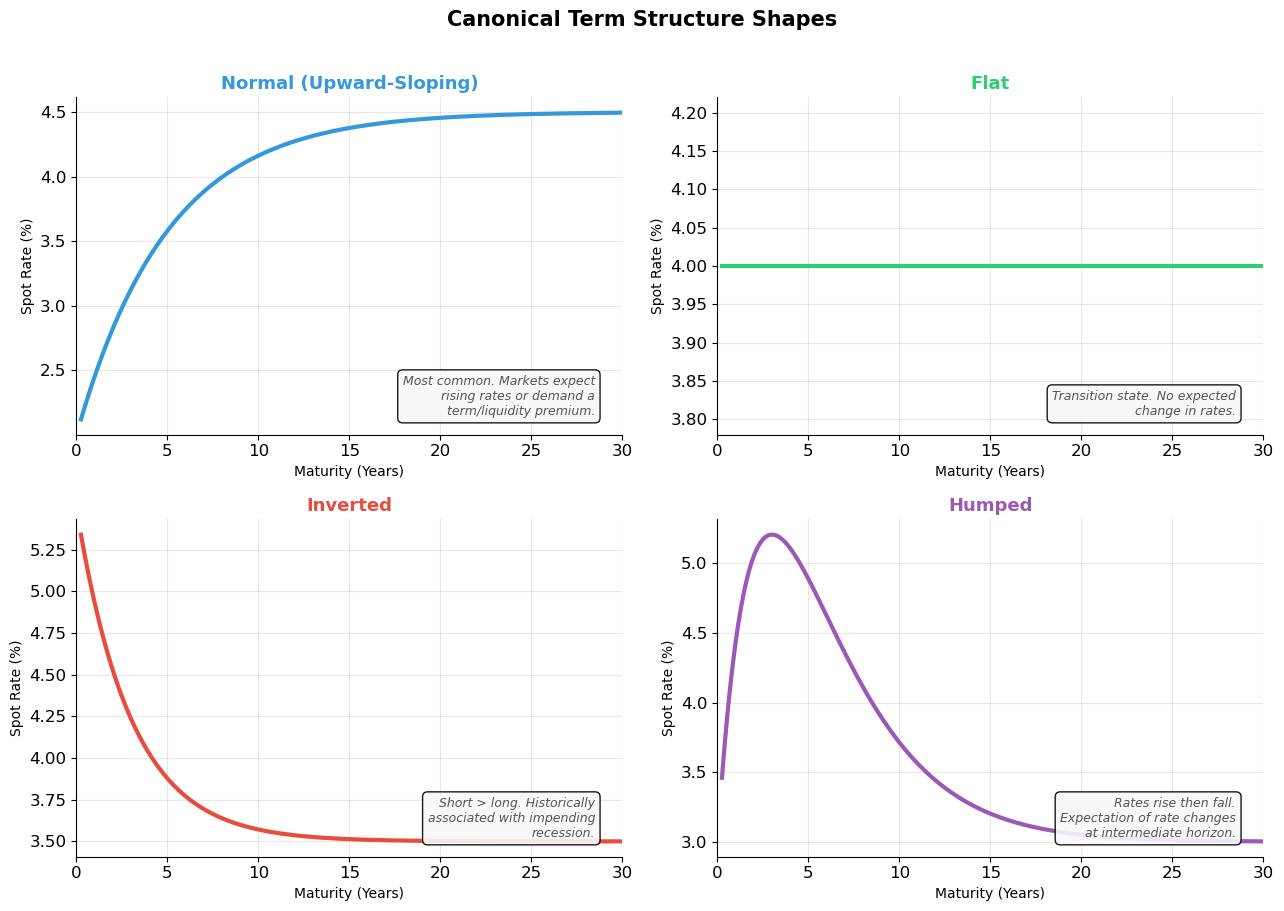

In [9]:
# ============================================================
# Term Structure Shapes — Illustrative Examples
# ============================================================
T = np.linspace(0.25, 30, 200)

# Four canonical shapes
normal = 2 + 2.5 * (1 - np.exp(-T / 5))
flat = np.ones_like(T) * 4.0
inverted = 5.5 - 2 * (1 - np.exp(-T / 3))
humped = 3 + 2 * T * np.exp(-T / 3)

fig, axes = plt.subplots(2, 2, figsize=(13, 9))
configs = [
    (axes[0, 0], normal, 'Normal (Upward-Sloping)', '#3498db',
     'Most common. Markets expect\nrising rates or demand a\nterm/liquidity premium.'),
    (axes[0, 1], flat, 'Flat', '#2ecc71',
     'Transition state. No expected\nchange in rates.'),
    (axes[1, 0], inverted, 'Inverted', '#e74c3c',
     'Short > long. Historically\nassociated with impending\nrecession.'),
    (axes[1, 1], humped, 'Humped', '#9b59b6',
     'Rates rise then fall.\nExpectation of rate changes\nat intermediate horizon.'),
]

for ax, curve, title, color, note in configs:
    ax.plot(T, curve, color=color, linewidth=3)
    ax.set_xlabel('Maturity (Years)', fontsize=10)
    ax.set_ylabel('Spot Rate (%)', fontsize=10)
    ax.set_title(title, fontsize=13, fontweight='bold', color=color)
    ax.set_xlim(0, 30)
    ax.text(0.95, 0.05, note, transform=ax.transAxes, ha='right', va='bottom',
            fontsize=9, style='italic', color='#555',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='#f8f8f8', alpha=0.9))

fig.suptitle('Canonical Term Structure Shapes', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

---

<a id='4-forward-rates'></a>
## 4. Forward Rates

### Extracting Forward Rates from Spot Rates

The **forward rate** $f_t$ is the interest rate for a one-year loan beginning at time $t-1$, as **implied by today's term structure**. It is not a forecast — it is an arbitrage-free rate locked in by current prices.

From the no-arbitrage condition:

$$(1 + r_{0,T})^T = (1 + r_{0,T-1})^{T-1} \times (1 + f_T)$$

Solving for the forward rate:

$$\boxed{f_T = \frac{(1 + r_{0,T})^T}{(1 + r_{0,T-1})^{T-1}} - 1}$$

**Intuition:** Investing for $T$ years at the $T$-year spot rate must give the same return as investing for $T-1$ years at the $(T-1)$-year spot rate and then reinvesting for one year at the forward rate $f_T$. Otherwise, there's an arbitrage.

### Lo's CFO Example

As the CFO of a US multinational, you expect to repatriate \$10M from a foreign subsidiary in one year, which will be used to pay dividends one year later. You want to lock in a lending rate from year 1 to year 2.

Current rates: $r_{0,1} = 5\%$ and $r_{0,2} = 7\%$

**Strategy:**
1. Borrow \$9.524M for 1 year at 5% (creates \$10M obligation at year 1)
2. Invest \$9.524M for 2 years at 7% (grows to \$10.904M at year 2)
3. At year 1, use the \$10M repatriation to repay the 1-year loan
4. At year 2, collect \$10.904M

**Result:** You've locked in a 1-year rate from year 1 to 2 of \$10.904M/\$10M - 1 = 9.04%. This is the **forward rate** $f_2$.

In [11]:
# ============================================================
# Forward Rate Extraction from Spot Rates
# ============================================================

def extract_forward_rates(maturities, spot_rates):
    """Extract 1-year forward rates from a set of spot rates.
    
    f_T = (1 + r_T)^T / (1 + r_{T-1})^{T-1} - 1
    """
    forwards = {}
    sorted_pairs = sorted(zip(maturities, spot_rates))
    
    for i in range(len(sorted_pairs)):
        T, r_T = sorted_pairs[i]
        if i == 0:
            forwards[T] = r_T  # First forward = first spot rate
        else:
            T_prev, r_prev = sorted_pairs[i - 1]
            if T - T_prev == 1:  # Only compute for integer-year gaps
                f = (1 + r_T)**T / (1 + r_prev)**T_prev - 1
                forwards[T] = f
    return forwards


# Example: Build a richer term structure for integer maturities
spot_rates_annual = {
    1: 0.0341,
    2: 0.0382,
    3: 0.0410,
    4: 0.0435,
    5: 0.0464,
    6: 0.0480,
    7: 0.0495,
    8: 0.0505,
    9: 0.0512,
    10: 0.0515,
}

forwards = extract_forward_rates(
    list(spot_rates_annual.keys()),
    list(spot_rates_annual.values())
)

print("=" * 65)
print("SPOT RATES AND IMPLIED FORWARD RATES")
print("=" * 65)
print(f"{'Maturity':>10s} {'Spot Rate':>12s} {'Forward Rate':>14s} {'Interpretation':>25s}")
print("-" * 65)
for T in sorted(spot_rates_annual.keys()):
    r = spot_rates_annual[T]
    f = forwards.get(T, None)
    if f is not None:
        interp = f"1yr rate in year {T}"
        print(f"{T:>10d} {r:>12.4%} {f:>14.4%} {interp:>25s}")

# Verify: compounding forward rates should recover spot rates
print("\n--- Verification: Forward rates compound to spot rates ---")
cumulative = 1.0
for T in range(1, 11):
    cumulative *= (1 + forwards[T])
    implied_spot = cumulative**(1/T) - 1
    actual_spot = spot_rates_annual[T]
    check = '✓' if abs(implied_spot - actual_spot) < 1e-10 else '✗'
    print(f"  T={T:>2d}: (1+f1)×...×(1+f{T})^(1/{T}) = {implied_spot:.4%} vs r_{T} = {actual_spot:.4%}  {check}")

SPOT RATES AND IMPLIED FORWARD RATES
  Maturity    Spot Rate   Forward Rate            Interpretation
-----------------------------------------------------------------
         1      3.4100%        3.4100%        1yr rate in year 1
         2      3.8200%        4.2316%        1yr rate in year 2
         3      4.1000%        4.6623%        1yr rate in year 3
         4      4.3500%        5.1036%        1yr rate in year 4
         5      4.6400%        5.8081%        1yr rate in year 5
         6      4.8000%        5.6037%        1yr rate in year 6
         7      4.9500%        5.8545%        1yr rate in year 7
         8      5.0500%        5.7527%        1yr rate in year 8
         9      5.1200%        5.6817%        1yr rate in year 9
        10      5.1500%        5.4204%       1yr rate in year 10

--- Verification: Forward rates compound to spot rates ---
  T= 1: (1+f1)×...×(1+f1)^(1/1) = 3.4100% vs r_1 = 3.4100%  ✓
  T= 2: (1+f1)×...×(1+f2)^(1/2) = 3.8200% vs r_2 = 3.8200%  

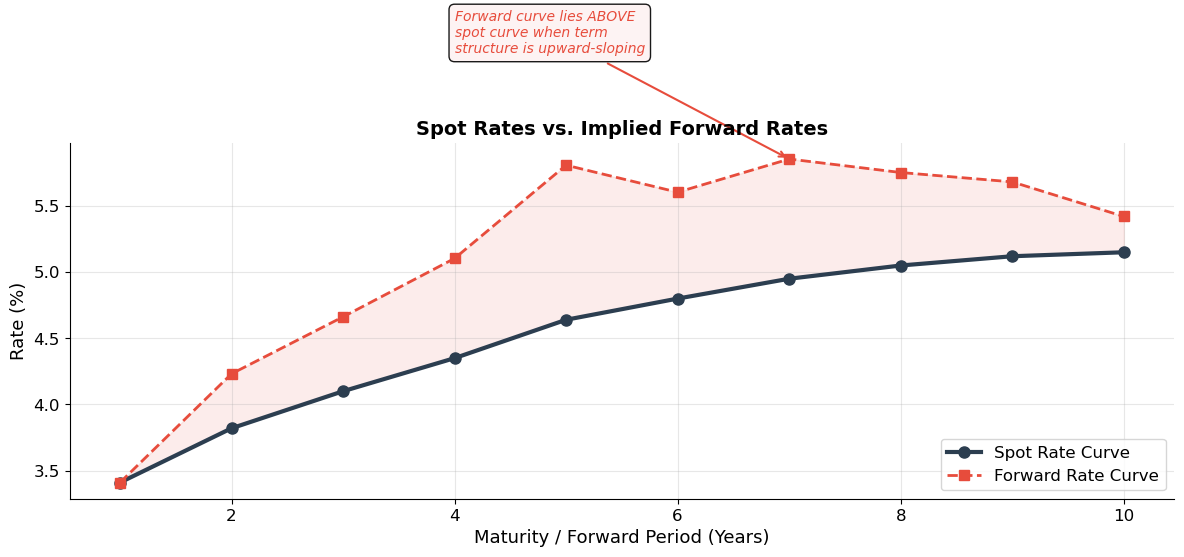

Key Insight: When the spot curve is upward-sloping, forward rates
exceed spot rates. Intuitively, if long rates are higher than short
rates, the 'marginal' rate for the next year must be even higher
to pull up the average.


In [12]:
# ============================================================
# Visualization: Spot Curve vs. Forward Curve
# ============================================================
T_vals = sorted(spot_rates_annual.keys())
spot_vals = [spot_rates_annual[T] * 100 for T in T_vals]
fwd_vals = [forwards[T] * 100 for T in T_vals]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(T_vals, spot_vals, 'o-', color='#2c3e50', linewidth=3, markersize=8, label='Spot Rate Curve', zorder=3)
ax.plot(T_vals, fwd_vals, 's--', color='#e74c3c', linewidth=2, markersize=7, label='Forward Rate Curve', zorder=3)
ax.fill_between(T_vals, spot_vals, fwd_vals, alpha=0.1, color='#e74c3c')

ax.set_xlabel('Maturity / Forward Period (Years)', fontsize=13)
ax.set_ylabel('Rate (%)', fontsize=13)
ax.set_title('Spot Rates vs. Implied Forward Rates', fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc='lower right')

# Annotate key insight
ax.annotate('Forward curve lies ABOVE\nspot curve when term\nstructure is upward-sloping',
            xy=(7, fwd_vals[6]), xytext=(4, fwd_vals[6] + 0.8),
            fontsize=10, color='#e74c3c', style='italic',
            arrowprops=dict(arrowstyle='->', color='#e74c3c', lw=1.5),
            bbox=dict(boxstyle='round,pad=0.4', facecolor='#fdf2f2', alpha=0.9))

plt.tight_layout()
plt.show()

print("Key Insight: When the spot curve is upward-sloping, forward rates")
print("exceed spot rates. Intuitively, if long rates are higher than short")
print("rates, the 'marginal' rate for the next year must be even higher")
print("to pull up the average.")

In [13]:
# ============================================================
# Lo's CFO Example: Locking in a Forward Rate
# ============================================================
r1 = 0.05   # 1-year spot rate
r2 = 0.07   # 2-year spot rate
repatriation = 10_000_000  # $10M arriving at year 1

# Implied forward rate
f2 = (1 + r2)**2 / (1 + r1) - 1

# Strategy
borrow_amount = repatriation / (1 + r1)  # Borrow this much at year 0
invest_amount = borrow_amount              # Invest same amount for 2 years
year2_proceeds = invest_amount * (1 + r2)**2
year1_repayment = repatriation

print("=" * 60)
print("CFO FORWARD RATE LOCK — Lo's Example")
print("=" * 60)
print(f"1-year spot rate:      {r1:.2%}")
print(f"2-year spot rate:      {r2:.2%}")
print(f"Implied forward rate:  {f2:.4%}")
print()

# Cash flow table
cf_data = {
    'Transaction': [
        'Borrow for 1 year at 5%',
        'Invest for 2 years at 7%',
        'Repatriation received',
        'Repay 1-year loan',
        'Collect 2-year investment',
        'NET'
    ],
    'Year 0': [
        f'+${borrow_amount:,.0f}', f'-${invest_amount:,.0f}', '—', '—', '—', '$0'
    ],
    'Year 1': [
        '—', '—', f'+${repatriation:,.0f}', f'-${year1_repayment:,.0f}', '—', '$0'
    ],
    'Year 2': [
        '—', '—', '—', '—', f'+${year2_proceeds:,.0f}', f'+${year2_proceeds:,.0f}'
    ]
}
df = pd.DataFrame(cf_data)
print(df.to_string(index=False))
print(f"\n→ Effective lending rate (year 1→2): ${year2_proceeds:,.0f} / ${repatriation:,.0f} - 1 = {year2_proceeds/repatriation - 1:.4%}")
print(f"  This equals the forward rate f₂ = {f2:.4%} ✓")

CFO FORWARD RATE LOCK — Lo's Example
1-year spot rate:      5.00%
2-year spot rate:      7.00%
Implied forward rate:  9.0381%

              Transaction      Year 0       Year 1       Year 2
  Borrow for 1 year at 5% +$9,523,810            —            —
 Invest for 2 years at 7% -$9,523,810            —            —
    Repatriation received           — +$10,000,000            —
        Repay 1-year loan           — -$10,000,000            —
Collect 2-year investment           —            — +$10,903,810
                      NET          $0           $0 +$10,903,810

→ Effective lending rate (year 1→2): $10,903,810 / $10,000,000 - 1 = 9.0381%
  This equals the forward rate f₂ = 9.0381% ✓


In [14]:
# ============================================================
# Forward Loan Example: Quoting a Rate for a Future Loan
# ============================================================
# From Lo's slides: Customer wants to borrow $20M in 3 years for 1 year
# Discount bond prices given:

bond_prices = {1: 0.9524, 2: 0.8900, 3: 0.8278, 4: 0.7629}

# Extract spot rates
spot_from_prices = {}
for T, P in bond_prices.items():
    spot_from_prices[T] = (1 / P)**(1/T) - 1

# Forward rate for year 3 to 4
f4 = (1 + spot_from_prices[4])**4 / (1 + spot_from_prices[3])**3 - 1

# Strategy to manufacture the forward loan
loan_desired = 20_000_000
buy_3yr = loan_desired  # Buy $20M of 3-year discount bonds
cost_3yr = buy_3yr * bond_prices[3]
sell_4yr_amount = cost_3yr / bond_prices[4]  # Sell 4-year bonds to finance

print("=" * 60)
print("FORWARD LOAN: Quoting a Rate for $20M Loan in 3 Years")
print("=" * 60)
print(f"\nDiscount bond prices and implied spot rates:")
for T, P in bond_prices.items():
    r = spot_from_prices[T]
    print(f"  B({T}yr) = ${P:.4f}  →  r(0,{T}) = {r:.4%}")

print(f"\nImplied 1-year forward rate for year 4: f₄ = {f4:.4%}")

print(f"\nStrategy:")
print(f"  1. Buy ${buy_3yr/1e6:.0f}M of 3-year bonds, costing ${cost_3yr/1e6:,.3f}M")
print(f"  2. Finance by selling 4-year bonds: ${cost_3yr/1e6:,.3f}M / {bond_prices[4]:.4f} = ${sell_4yr_amount/1e6:,.3f}M")
print(f"  3. Year 4 liability: ${sell_4yr_amount/1e6:,.3f}M")

print(f"\nCash flows (millions):")
print(f"  {'Year':>6s}  {'Buy 3yr':>10s}  {'Sell 4yr':>10s}  {'Net':>10s}")
print(f"  {'0':>6s}  {-cost_3yr/1e6:>+10.3f}  {cost_3yr/1e6:>+10.3f}  {'0.000':>10s}")
print(f"  {'1-2':>6s}  {'0.000':>10s}  {'0.000':>10s}  {'0.000':>10s}")
print(f"  {'3':>6s}  {buy_3yr/1e6:>+10.3f}  {'0.000':>10s}  {buy_3yr/1e6:>+10.3f}")
print(f"  {'4':>6s}  {'0.000':>10s}  {-sell_4yr_amount/1e6:>+10.3f}  {-sell_4yr_amount/1e6:>+10.3f}")

effective_rate = sell_4yr_amount / buy_3yr - 1
print(f"\n→ Quoted rate: ${sell_4yr_amount/1e6:,.3f}M / ${buy_3yr/1e6:,.0f}M - 1 = {effective_rate:.4%}")
print(f"  This equals the forward rate f₄ = {f4:.4%} ✓")

FORWARD LOAN: Quoting a Rate for $20M Loan in 3 Years

Discount bond prices and implied spot rates:
  B(1yr) = $0.9524  →  r(0,1) = 4.9979%
  B(2yr) = $0.8900  →  r(0,2) = 5.9998%
  B(3yr) = $0.8278  →  r(0,3) = 6.5021%
  B(4yr) = $0.7629  →  r(0,4) = 6.9998%

Implied 1-year forward rate for year 4: f₄ = 8.5070%

Strategy:
  1. Buy $20M of 3-year bonds, costing $16.556M
  2. Finance by selling 4-year bonds: $16.556M / 0.7629 = $21.701M
  3. Year 4 liability: $21.701M

Cash flows (millions):
    Year     Buy 3yr    Sell 4yr         Net
       0     -16.556     +16.556       0.000
     1-2       0.000       0.000       0.000
       3     +20.000       0.000     +20.000
       4       0.000     -21.701     -21.701

→ Quoted rate: $21.701M / $20M - 1 = 8.5070%
  This equals the forward rate f₄ = 8.5070% ✓


---

<a id='5-coupon-bonds'></a>
## 5. Valuation of Coupon Bonds

### Coupon Bond Cash Flows

A coupon bond with face value $F$, coupon rate $c$, and maturity $T$ pays:
- **Coupon** of $C = c \times F$ at times $t = 1, 2, \ldots, T$
- **Principal** $F$ at maturity $T$

For example, a 3-year, 5% coupon, \$1,000 par bond pays: \$50, \$50, \$1,050.

### Method 1: Price Using Spot Rates

The theoretically correct method prices each cash flow using the **appropriate spot rate** for its maturity:

$$\boxed{P = \frac{C}{(1+r_{0,1})} + \frac{C}{(1+r_{0,2})^2} + \cdots + \frac{C + F}{(1+r_{0,T})^T}}$$

### Method 2: Coupon Bond as a Portfolio of Discount Bonds

**Theorem (Lo):** All coupon bonds are portfolios of pure discount bonds.

A 3-year, 5% coupon, \$1,000 par bond is equivalent to holding:
- 50 units of 1-year STRIPS
- 50 units of 2-year STRIPS
- 1,050 units of 3-year STRIPS

Therefore:

$$P = C \cdot B_1 + C \cdot B_2 + \cdots + (C + F) \cdot B_T$$

where $B_t$ is the price of a discount bond paying \$1 at time $t$.

**If this relation is violated, arbitrage opportunities exist.**

In [16]:
# ============================================================
# Coupon Bond Pricing — Two Methods
# ============================================================

def price_bond_spot_rates(face, coupon_rate, maturity, spot_rates_dict):
    """Price a coupon bond using individual spot rates."""
    C = face * coupon_rate
    price = 0
    for t in range(1, maturity + 1):
        cf = C if t < maturity else C + face
        r = spot_rates_dict[t]
        price += cf / (1 + r)**t
    return price

def price_bond_discount(face, coupon_rate, maturity, discount_prices):
    """Price a coupon bond as portfolio of discount bonds."""
    C = face * coupon_rate
    price = 0
    for t in range(1, maturity + 1):
        cf = C if t < maturity else C + face
        price += cf * discount_prices[t]
    return price

# Example: 3-year, 5% coupon, $1,000 par
face = 1000
coupon_rate = 0.05
maturity = 3
C = face * coupon_rate

# Use our spot rates (first 3)
spots = {1: 0.0341, 2: 0.0382, 3: 0.0410}
disc_prices = {t: 1 / (1 + r)**t for t, r in spots.items()}

price_method1 = price_bond_spot_rates(face, coupon_rate, maturity, spots)
price_method2 = price_bond_discount(face, coupon_rate, maturity, disc_prices)

print("=" * 65)
print("COUPON BOND PRICING — 3-Year, 5% Coupon, $1,000 Par")
print("=" * 65)

# Method 1
print("\nMethod 1: Discount each cash flow at its spot rate")
print(f"{'Period':>8s} {'CF':>10s} {'Spot Rate':>12s} {'Disc Factor':>14s} {'PV':>12s}")
print("-" * 60)
total_pv = 0
for t in range(1, maturity + 1):
    cf = C if t < maturity else C + face
    r = spots[t]
    df = 1 / (1 + r)**t
    pv = cf * df
    total_pv += pv
    print(f"{t:>8d} {cf:>10,.0f} {r:>12.4%} {df:>14.6f} {pv:>12,.2f}")
print("-" * 60)
print(f"{'PRICE':>8s} {'':>10s} {'':>12s} {'':>14s} {total_pv:>12,.2f}")

# Method 2
print(f"\nMethod 2: Portfolio of discount bonds")
print(f"  50 × B₁ + 50 × B₂ + 1050 × B₃")
for t in range(1, maturity + 1):
    cf = C if t < maturity else C + face
    print(f"  {cf:,.0f} × {disc_prices[t]:.6f} = {cf * disc_prices[t]:,.2f}")
print(f"  PRICE = ${price_method2:,.2f}")
print(f"\n✅ Both methods give: ${price_method1:,.2f} = ${price_method2:,.2f}")

COUPON BOND PRICING — 3-Year, 5% Coupon, $1,000 Par

Method 1: Discount each cash flow at its spot rate
  Period         CF    Spot Rate    Disc Factor           PV
------------------------------------------------------------
       1         50      3.4100%       0.967024        48.35
       2         50      3.8200%       0.927765        46.39
       3      1,050      4.1000%       0.886437       930.76
------------------------------------------------------------
   PRICE                                            1,025.50

Method 2: Portfolio of discount bonds
  50 × B₁ + 50 × B₂ + 1050 × B₃
  50 × 0.967024 = 48.35
  50 × 0.927765 = 46.39
  1,050 × 0.886437 = 930.76
  PRICE = $1,025.50

✅ Both methods give: $1,025.50 = $1,025.50


---

<a id='6-ytm'></a>
## 6. Yield to Maturity (YTM)

### The Problem with Spot Rates

In practice, we often don't observe the full term structure of spot rates. Instead, bond markets quote a single summary statistic: the **yield to maturity (YTM)**.

### Definition

The YTM $y$ is the **single discount rate** that, when applied to all cash flows, reproduces the bond's market price:

$$\boxed{P = \frac{C}{(1+y)} + \frac{C}{(1+y)^2} + \cdots + \frac{C+F}{(1+y)^T}}$$

The YTM is a **complex average** of all the individual spot rates. There is generally no closed-form solution — it must be computed numerically (root-finding on a $T$-th degree polynomial).

### Key Properties

1. **For zero-coupon bonds:** YTM = spot rate (trivially)
2. **$(P, y, C)$ are over-determined**: given any two, the third is determined
3. **Coupon bond trading at par** $(P = F)$: YTM = coupon rate
4. **Premium bond** $(P > F)$: YTM < coupon rate
5. **Discount bond** $(P < F)$: YTM > coupon rate

In [18]:
# ============================================================
# Computing Yield to Maturity — Numerical Methods
# ============================================================

def bond_price_from_ytm(face, coupon_rate, maturity, ytm, freq=1):
    """Price a bond given YTM. freq=1 for annual, 2 for semi-annual."""
    C = face * coupon_rate / freq
    n = maturity * freq
    y = ytm / freq
    price = sum(C / (1 + y)**t for t in range(1, n + 1))
    price += face / (1 + y)**n
    return price

def compute_ytm(price, face, coupon_rate, maturity, freq=1, guess=0.05):
    """Compute YTM numerically using Brent's method."""
    def f(y):
        return bond_price_from_ytm(face, coupon_rate, maturity, y, freq) - price
    return brentq(f, -0.05, 2.0)


# Example 1: Our 3-year, 5% bond priced at $1,029.22
price_3yr = price_method1
ytm_3yr = compute_ytm(price_3yr, 1000, 0.05, 3)
price_check = bond_price_from_ytm(1000, 0.05, 3, ytm_3yr)

print("Example 1: 3-Year, 5% Coupon Bond")
print(f"  Market price (from spot rates): ${price_3yr:,.2f}")
print(f"  Yield to maturity:              {ytm_3yr:.4%}")
print(f"  Price at YTM (verification):    ${price_check:,.2f} ✓")
print(f"  Spot rates: r₁={spots[1]:.2%}, r₂={spots[2]:.2%}, r₃={spots[3]:.2%}")
print(f"  YTM is a weighted average:      {ytm_3yr:.2%} (between r₁ and r₃)")

# Example 2: Premium, par, and discount bonds
print("\n" + "=" * 65)
print("PREMIUM, PAR, AND DISCOUNT BONDS")
print("=" * 65)
print(f"{'Coupon':>8s} {'Price':>10s} {'vs Par':>10s} {'YTM':>10s} {'YTM vs Coupon':>15s}")
print("-" * 55)
for c_rate in [0.02, 0.04, 0.05, 0.06, 0.08]:
    p = bond_price_from_ytm(1000, c_rate, 10, 0.05)
    ytm_check = compute_ytm(p, 1000, c_rate, 10)
    status = 'Par' if abs(p - 1000) < 0.01 else ('Premium' if p > 1000 else 'Discount')
    relation = 'YTM = c' if abs(ytm_check - c_rate) < 1e-6 else ('YTM < c' if ytm_check < c_rate else 'YTM > c')
    print(f"{c_rate:>8.0%} {p:>10,.2f} {status:>10s} {ytm_check:>10.2%} {relation:>15s}")

Example 1: 3-Year, 5% Coupon Bond
  Market price (from spot rates): $1,025.50
  Yield to maturity:              4.0798%
  Price at YTM (verification):    $1,025.50 ✓
  Spot rates: r₁=3.41%, r₂=3.82%, r₃=4.10%
  YTM is a weighted average:      4.08% (between r₁ and r₃)

PREMIUM, PAR, AND DISCOUNT BONDS
  Coupon      Price     vs Par        YTM   YTM vs Coupon
-------------------------------------------------------
      2%     768.35   Discount      5.00%         YTM > c
      4%     922.78   Discount      5.00%         YTM > c
      5%   1,000.00        Par      5.00%         YTM = c
      6%   1,077.22    Premium      5.00%         YTM < c
      8%   1,231.65    Premium      5.00%         YTM < c


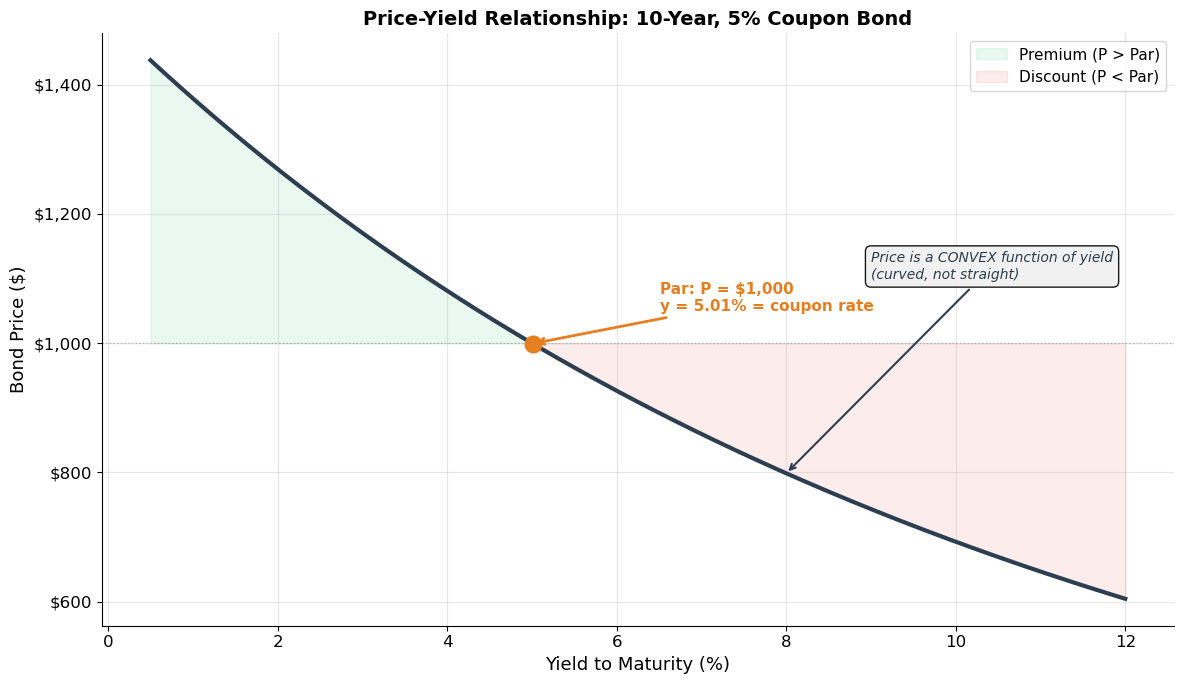

Key observations:
1. Price and yield move in OPPOSITE directions (inverse relationship)
2. The relationship is CONVEX (curved, not linear) — this matters for risk!
3. At par: price = $1,000 when yield = coupon rate (5%)


In [19]:
# ============================================================
# Visualization: YTM and the Price-Yield Relationship
# ============================================================
# ▶ MODIFY AND RE-RUN
face = 1000
coupon_rate = 0.05
maturity = 10
# ============================================================

yields = np.linspace(0.005, 0.12, 200)
prices = [bond_price_from_ytm(face, coupon_rate, maturity, y) for y in yields]

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(yields * 100, prices, color='#2c3e50', linewidth=3)

# Annotate key points
par_idx = np.argmin(np.abs(np.array(prices) - face))
ax.plot(yields[par_idx] * 100, prices[par_idx], 'o', color='#e67e22', markersize=12, zorder=5)
ax.annotate(f'Par: P = ${face:,.0f}\ny = {yields[par_idx]:.2%} = coupon rate',
            xy=(yields[par_idx] * 100, prices[par_idx]),
            xytext=(yields[par_idx] * 100 + 1.5, prices[par_idx] + 50),
            fontsize=11, fontweight='bold', color='#e67e22',
            arrowprops=dict(arrowstyle='->', color='#e67e22', lw=2))

# Premium and discount zones
ax.fill_between(yields * 100, prices, face, where=np.array(prices) > face,
                alpha=0.1, color='#2ecc71', label='Premium (P > Par)')
ax.fill_between(yields * 100, prices, face, where=np.array(prices) < face,
                alpha=0.1, color='#e74c3c', label='Discount (P < Par)')
ax.axhline(y=face, color='gray', linewidth=1, linestyle=':', alpha=0.5)

# Show convexity
ax.annotate('Price is a CONVEX function of yield\n(curved, not straight)',
            xy=(8, bond_price_from_ytm(face, coupon_rate, maturity, 0.08)),
            xytext=(9, 1100), fontsize=10, color='#2c3e50', style='italic',
            arrowprops=dict(arrowstyle='->', color='#2c3e50', lw=1.5),
            bbox=dict(boxstyle='round,pad=0.4', facecolor='#f0f0f0', alpha=0.9))

ax.set_xlabel('Yield to Maturity (%)', fontsize=13)
ax.set_ylabel('Bond Price ($)', fontsize=13)
ax.set_title(f'Price-Yield Relationship: {maturity}-Year, {coupon_rate:.0%} Coupon Bond',
             fontsize=14, fontweight='bold')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("Key observations:")
print("1. Price and yield move in OPPOSITE directions (inverse relationship)")
print("2. The relationship is CONVEX (curved, not linear) — this matters for risk!")
print("3. At par: price = $1,000 when yield = coupon rate (5%)")

---

<a id='7-bond-properties'></a>
## 7. Bond Price Properties

### The Inverse Relationship

$$\frac{\partial P}{\partial y} < 0$$

When yields rise, bond prices fall — and vice versa. This is the fundamental source of **interest rate risk** for bond investors.

### Sensitivity Depends on Maturity and Coupon

**Longer maturity** → more sensitive to yield changes (more cash flows far in the future, more heavily discounted).

**Lower coupon** → more sensitive to yield changes (more of the bond's value comes from the distant principal payment).

A zero-coupon bond is the *most* sensitive for a given maturity.

### Pull to Par

As a bond approaches maturity, its price converges to the face value — regardless of whether it was trading at a premium or discount. This is the **pull-to-par** effect.

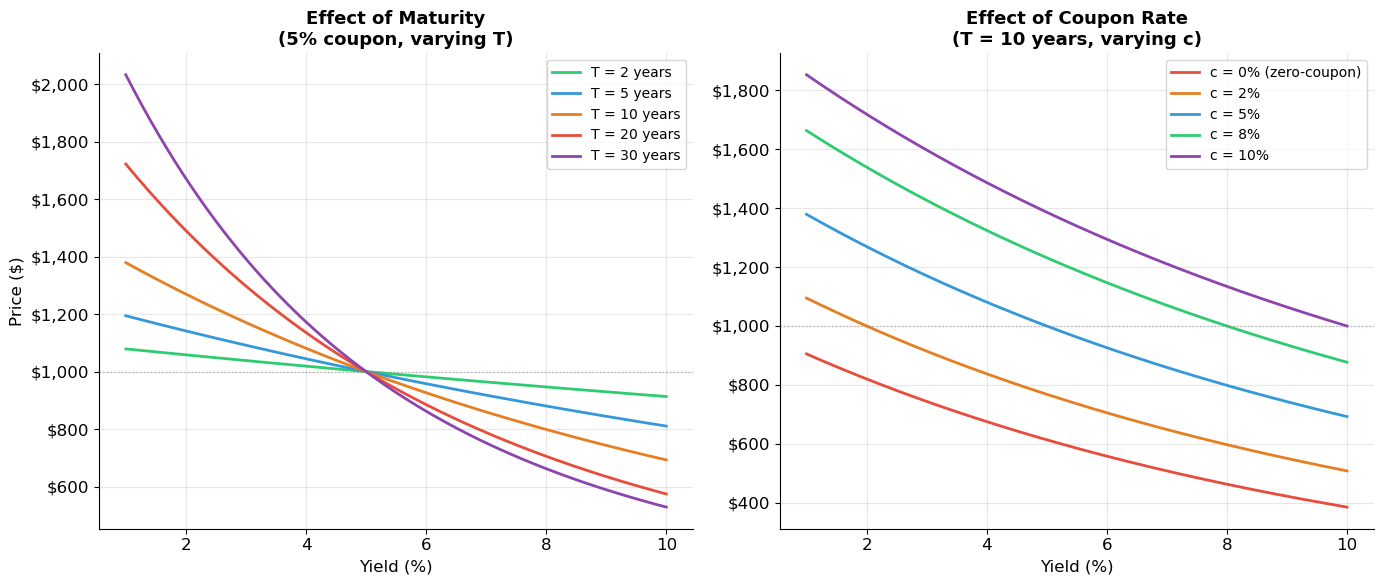

Key insights:
• Longer maturity → steeper price-yield curve → MORE interest rate risk
• Lower coupon → steeper price-yield curve → MORE interest rate risk
• Zero-coupon bonds are the MOST sensitive (all value in the terminal payment)


In [21]:
# ============================================================
# Sensitivity: Maturity and Coupon Effects
# ============================================================
yields = np.linspace(0.01, 0.10, 200)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Different maturities, same coupon
colors_m = ['#2ecc71', '#3498db', '#e67e22', '#e74c3c', '#8e44ad']
for T, color in zip([2, 5, 10, 20, 30], colors_m):
    prices = [bond_price_from_ytm(1000, 0.05, T, y) for y in yields]
    ax1.plot(yields * 100, prices, color=color, linewidth=2, label=f'T = {T} years')

ax1.axhline(y=1000, color='gray', linewidth=1, linestyle=':', alpha=0.5)
ax1.set_xlabel('Yield (%)', fontsize=12)
ax1.set_ylabel('Price ($)', fontsize=12)
ax1.set_title('Effect of Maturity\n(5% coupon, varying T)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Right: Different coupons, same maturity
colors_c = ['#e74c3c', '#e67e22', '#3498db', '#2ecc71', '#8e44ad']
for c, color in zip([0.00, 0.02, 0.05, 0.08, 0.10], colors_c):
    prices = [bond_price_from_ytm(1000, c, 10, y) for y in yields]
    label = f'c = {c:.0%}' + (' (zero-coupon)' if c == 0 else '')
    ax2.plot(yields * 100, prices, color=color, linewidth=2, label=label)

ax2.axhline(y=1000, color='gray', linewidth=1, linestyle=':', alpha=0.5)
ax2.set_xlabel('Yield (%)', fontsize=12)
ax2.set_title('Effect of Coupon Rate\n(T = 10 years, varying c)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

print("Key insights:")
print("• Longer maturity → steeper price-yield curve → MORE interest rate risk")
print("• Lower coupon → steeper price-yield curve → MORE interest rate risk")
print("• Zero-coupon bonds are the MOST sensitive (all value in the terminal payment)")

In [22]:
# ============================================================
# Pull to Par — Bond Price Convergence Over Time
# ============================================================
# ▶ MODIFY AND RE-RUN
face = 1000
coupon_rate = 0.05
original_maturity = 20
market_yield = 0.07  # Bond bought when yields = 7% (discount bond)
# ============================================================

# Track price as remaining maturity shrinks
remaining = np.arange(original_maturity, 0, -0.25)
prices_discount = [bond_price_from_ytm(face, coupon_rate, T, market_yield) for T in remaining]

# Also a premium bond (yields = 3%)
prices_premium = [bond_price_from_ytm(face, coupon_rate, T, 0.03) for T in remaining]

# And a par bond
prices_par = [bond_price_from_ytm(face, coupon_rate, T, coupon_rate) for T in remaining]

fig, ax = plt.subplots(figsize=(12, 6))
time_elapsed = original_maturity - remaining

ax.plot(time_elapsed, prices_discount, color='#e74c3c', linewidth=2.5, label=f'Discount (y = {market_yield:.0%})')
ax.plot(time_elapsed, prices_premium, color='#2ecc71', linewidth=2.5, label='Premium (y = 3%)')
ax.plot(time_elapsed, prices_par, color='#3498db', linewidth=2, linestyle='--', label=f'Par (y = {coupon_rate:.0%})')
ax.axhline(y=face, color='#2c3e50', linewidth=1.5, linestyle=':', alpha=0.7)
ax.text(original_maturity * 0.95, face + 10, f'Par = ${face:,.0f}', fontsize=11, color='#2c3e50')

ax.set_xlabel('Years Elapsed', fontsize=12)
ax.set_ylabel('Bond Price ($)', fontsize=12)
ax.set_title(f'Pull to Par: {original_maturity}-Year, {coupon_rate:.0%} Coupon Bond\n(Assuming constant yields)',
             fontsize=14, fontweight='bold')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.legend(fontsize=11)
ax.annotate('All bonds converge\nto par at maturity', xy=(original_maturity - 1, face),
            xytext=(original_maturity - 5, face - 100), fontsize=11, style='italic',
            arrowprops=dict(arrowstyle='->', color='#2c3e50', lw=1.5))

plt.tight_layout()
plt.show()

TypeError: 'numpy.float64' object cannot be interpreted as an integer

---

<a id='8-exercises'></a>
## 8. Exercises

### Exercise 1: STRIPS and Spot Rates

STRIPS are trading at the following prices (per \$1 face):

| Maturity | 1 yr | 2 yr | 3 yr | 4 yr | 5 yr |
|----------|------|------|------|------|------|
| Price | 0.9615 | 0.9151 | 0.8638 | 0.8096 | 0.7536 |

**(a)** Extract the spot rate for each maturity.

**(b)** Compute all one-year forward rates ($f_2, f_3, f_4, f_5$).

**(c)** Verify that compounding forward rates recovers the spot rates.

**(d)** Is the term structure normal, inverted, or humped? What does the forward curve tell you about market expectations?

In [ ]:
# Exercise 1 — Workspace
# strip_prices = {1: 0.9615, 2: 0.9151, 3: 0.8638, 4: 0.8096, 5: 0.7536}
#
# (a) Spot rates
# for T, P in strip_prices.items():
#     r = (1/P)**(1/T) - 1
#     print(f"r(0,{T}) = {r:.4%}")
#
# (b) Forward rates
# spots = {T: (1/P)**(1/T) - 1 for T, P in strip_prices.items()}
# for T in range(2, 6):
#     f = (1 + spots[T])**T / (1 + spots[T-1])**(T-1) - 1
#     print(f"f_{T} = {f:.4%}")

### Exercise 2: Coupon Bond Pricing

Using the STRIPS prices from Exercise 1:

**(a)** Price a 5-year, 6% annual coupon bond with \$1,000 face value using spot rates.

**(b)** Compute the yield to maturity. How does it compare to the 5-year spot rate?

**(c)** Is this bond trading at a premium, discount, or par? Explain why.

**(d)** A trader observes this bond trading at \$1,055 in the market. Is there an arbitrage? If so, describe the strategy and calculate the profit.

In [ ]:
# Exercise 2 — Workspace
# strip_prices = {1: 0.9615, 2: 0.9151, 3: 0.8638, 4: 0.8096, 5: 0.7536}
# spots = {T: (1/P)**(1/T) - 1 for T, P in strip_prices.items()}
#
# (a) Price with spot rates
# face, coupon_rate, T = 1000, 0.06, 5
# C = face * coupon_rate
# price = sum(C / (1 + spots[t])**t for t in range(1, T)) + (C + face) / (1 + spots[T])**T
# print(f"Bond price: ${price:,.2f}")
#
# (b) YTM
# ytm = compute_ytm(price, face, coupon_rate, T)
# print(f"YTM: {ytm:.4%} vs r(0,5) = {spots[5]:.4%}")

### Exercise 3: Forward Rate Applications

**(a)** You observe 1-year and 2-year spot rates of 3% and 4% respectively. What is the implied forward rate $f_2$? If you believe the 1-year rate next year will be 4.5%, do you invest for 2 years at 4% or invest for 1 year at 3% and roll over? Explain.

**(b)** The following zero-coupon bond prices are observed:

| Maturity | 1 yr | 2 yr | 3 yr |
|----------|------|------|------|
| Price | 0.9709 | 0.9335 | 0.8890 |

A client wants to borrow \$5M in 2 years for 1 year. What rate should you quote? Describe the replicating strategy.

**(c)** If the expectations hypothesis holds ($E[R_t] = f_t$), what does an upward-sloping term structure imply about future short-term rates? If the liquidity preference hypothesis holds instead, what changes?

In [ ]:
# Exercise 3 — Workspace
# (a)
# r1, r2 = 0.03, 0.04
# f2 = (1 + r2)**2 / (1 + r1) - 1
# print(f"Implied forward rate f₂ = {f2:.4%}")
# # Compare: investing 2yr at 4% vs 1yr at 3% then 1yr at 4.5%
# return_2yr = (1 + r2)**2
# return_roll = (1 + r1) * (1 + 0.045)
# print(f"2-year strategy: {return_2yr:.6f}")
# print(f"Roll-over strategy: {return_roll:.6f}")
# print(f"Better strategy: {'Roll-over' if return_roll > return_2yr else '2-year lock-in'}")
#
# (b)
# prices_ex = {1: 0.9709, 2: 0.9335, 3: 0.8890}
# spots_ex = {T: (1/P)**(1/T) - 1 for T, P in prices_ex.items()}
# f3 = (1 + spots_ex[3])**3 / (1 + spots_ex[2])**2 - 1
# print(f"Quote for 1-year loan starting in 2 years: {f3:.4%}")

---

## Key Takeaways — Session 4

1. **Fixed-income securities** are the largest asset class globally. Their cash flows are contractually fixed (in nominal terms), making valuation a direct NPV application.

2. **Discount bonds (STRIPS)** are the building blocks. Their prices directly reveal **spot rates** — the market's required return for each maturity.

3. **The term structure** (spot rates plotted against maturity) contains rich information about market expectations and risk preferences.

4. **Forward rates** are extracted from the term structure via no-arbitrage. They represent the rate for a future loan *implied* by current prices — not a forecast, but an arbitrage-free pricing tool.

5. **Coupon bonds = portfolios of discount bonds.** This allows pricing via replication and is the basis for **fixed-income arbitrage**.

6. **Yield to maturity** is a convenient summary measure — the single rate that prices all cash flows — but it is a **complex average** of spot rates, not the "true" discount rate for any particular cash flow.

7. **Bond prices are convex** in yield: the price-yield relationship curves, not lines. Longer maturity and lower coupon → greater sensitivity to yield changes.

---

## References

- **Brealey, R.A., Myers, S.C., and Allen, F.** *Principles of Corporate Finance*, Chapters 23–25.
- **MIT OCW 15.401:** [Fixed-Income Securities](https://ocw.mit.edu/courses/15-401-finance-theory-i-fall-2008/pages/video-lectures-and-slides/fixed-income-securities/)
- **Sundaresan, S.** (1997). *Fixed Income Markets and Their Derivatives*. South-Western.
- **Tuckman, B.** (1995). *Fixed Income Securities: Tools for Today's Markets*. Wiley.

---

*Next: **Session 5 — Fixed-Income Securities II** — Duration, convexity, immunization, corporate bonds, credit risk, and the sub-prime crisis securitization example.*